In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "int97"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 176
Categorical features: 7
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 248
Categorical Columns: 7


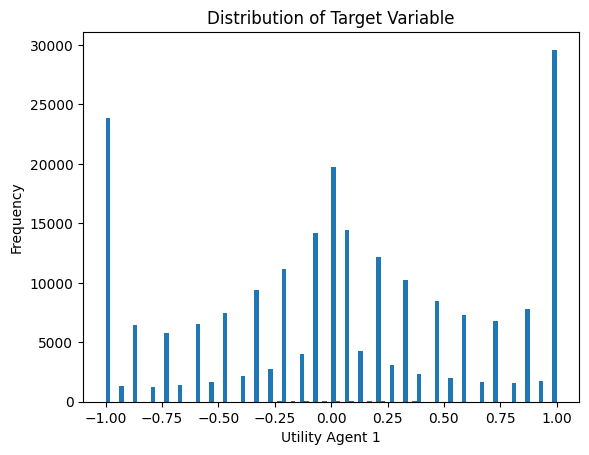

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55213


[100]	val-rmse:0.46760


[200]	val-rmse:0.44887


[300]	val-rmse:0.43892


[400]	val-rmse:0.43363


[500]	val-rmse:0.43116


[600]	val-rmse:0.42938


[700]	val-rmse:0.42806


[800]	val-rmse:0.42720


[900]	val-rmse:0.42666


[1000]	val-rmse:0.42601


[1100]	val-rmse:0.42558


[1200]	val-rmse:0.42543


[1300]	val-rmse:0.42526


[1400]	val-rmse:0.42525


[1500]	val-rmse:0.42527


[1600]	val-rmse:0.42517


[1700]	val-rmse:0.42519


[1800]	val-rmse:0.42524


[1900]	val-rmse:0.42516


[2000]	val-rmse:0.42534


[2100]	val-rmse:0.42537


[2200]	val-rmse:0.42540


[2300]	val-rmse:0.42543


[2400]	val-rmse:0.42544


[2499]	val-rmse:0.42538


Fold 1 - RMSE: 0.42506356620274766
Fold 2


[0]	val-rmse:0.58656


[100]	val-rmse:0.47629


[200]	val-rmse:0.45948


[300]	val-rmse:0.45243


[400]	val-rmse:0.44823


[500]	val-rmse:0.44561


[600]	val-rmse:0.44426


[700]	val-rmse:0.44328


[800]	val-rmse:0.44236


[900]	val-rmse:0.44168


[1000]	val-rmse:0.44113


[1100]	val-rmse:0.44093


[1200]	val-rmse:0.44056


[1300]	val-rmse:0.44025


[1400]	val-rmse:0.44011


[1500]	val-rmse:0.44002


[1600]	val-rmse:0.43996


[1700]	val-rmse:0.43989


[1800]	val-rmse:0.43980


[1900]	val-rmse:0.43969


[2000]	val-rmse:0.43968


[2100]	val-rmse:0.43965


[2200]	val-rmse:0.43963


[2300]	val-rmse:0.43966


[2400]	val-rmse:0.43970


[2499]	val-rmse:0.43972


Fold 2 - RMSE: 0.4393319231490051
Fold 3


[0]	val-rmse:0.60396


[100]	val-rmse:0.47986


[200]	val-rmse:0.45882


[300]	val-rmse:0.45091


[400]	val-rmse:0.44649


[500]	val-rmse:0.44385


[600]	val-rmse:0.44221


[700]	val-rmse:0.44096


[800]	val-rmse:0.43995


[900]	val-rmse:0.43917


[1000]	val-rmse:0.43872


[1100]	val-rmse:0.43842


[1200]	val-rmse:0.43804


[1300]	val-rmse:0.43789


[1400]	val-rmse:0.43774


[1500]	val-rmse:0.43764


[1600]	val-rmse:0.43747


[1700]	val-rmse:0.43733


[1800]	val-rmse:0.43722


[1900]	val-rmse:0.43723


[2000]	val-rmse:0.43706


[2100]	val-rmse:0.43701


[2200]	val-rmse:0.43718


[2300]	val-rmse:0.43703


[2400]	val-rmse:0.43704


[2499]	val-rmse:0.43697


Fold 3 - RMSE: 0.4365359318345519
Fold 4


[0]	val-rmse:0.59370


[100]	val-rmse:0.48201


[200]	val-rmse:0.46210


[300]	val-rmse:0.45372


[400]	val-rmse:0.44784


[500]	val-rmse:0.44497


[600]	val-rmse:0.44327


[700]	val-rmse:0.44209


[800]	val-rmse:0.44129


[900]	val-rmse:0.44058


[1000]	val-rmse:0.44020


[1100]	val-rmse:0.43994


[1200]	val-rmse:0.43960


[1300]	val-rmse:0.43920


[1400]	val-rmse:0.43905


[1500]	val-rmse:0.43889


[1600]	val-rmse:0.43867


[1700]	val-rmse:0.43852


[1800]	val-rmse:0.43832


[1900]	val-rmse:0.43815


[2000]	val-rmse:0.43813


[2100]	val-rmse:0.43808


[2200]	val-rmse:0.43805


[2300]	val-rmse:0.43799


[2400]	val-rmse:0.43795


[2499]	val-rmse:0.43785


Fold 4 - RMSE: 0.4374380171676669
Fold 5


[0]	val-rmse:0.54619


[100]	val-rmse:0.45826


[200]	val-rmse:0.43800


[300]	val-rmse:0.42571


[400]	val-rmse:0.41909


[500]	val-rmse:0.41602


[600]	val-rmse:0.41419


[700]	val-rmse:0.41253


[800]	val-rmse:0.41175


[900]	val-rmse:0.41095


[1000]	val-rmse:0.41057


[1100]	val-rmse:0.41010


[1200]	val-rmse:0.40983


[1300]	val-rmse:0.40982


[1400]	val-rmse:0.40971


[1500]	val-rmse:0.40977


[1600]	val-rmse:0.40985


[1700]	val-rmse:0.40972


[1800]	val-rmse:0.40972


[1900]	val-rmse:0.40969


[2000]	val-rmse:0.40961


[2100]	val-rmse:0.40960


[2200]	val-rmse:0.40959


[2300]	val-rmse:0.40966


[2400]	val-rmse:0.40971


[2499]	val-rmse:0.40970


Fold 5 - RMSE: 0.4093819885589871
List of oof scores: [0.42506356620274766, 0.4393319231490051, 0.4365359318345519, 0.4374380171676669, 0.4093819885589871]
Average oof score: 0.42955028538259177


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53457


[100]	val-rmse:0.44735


[200]	val-rmse:0.43105


[300]	val-rmse:0.42284


[400]	val-rmse:0.41805


[500]	val-rmse:0.41525


[600]	val-rmse:0.41366


[700]	val-rmse:0.41244


[800]	val-rmse:0.41124


[900]	val-rmse:0.41040


[1000]	val-rmse:0.40969


[1100]	val-rmse:0.40914


[1200]	val-rmse:0.40888


[1300]	val-rmse:0.40856


[1400]	val-rmse:0.40841


[1500]	val-rmse:0.40823


[1600]	val-rmse:0.40806


[1700]	val-rmse:0.40795


[1800]	val-rmse:0.40774


[1900]	val-rmse:0.40764


[2000]	val-rmse:0.40760


[2100]	val-rmse:0.40765


[2200]	val-rmse:0.40768


[2300]	val-rmse:0.40760


[2400]	val-rmse:0.40757


[2499]	val-rmse:0.40745


Fold 1 - RMSE: 0.4072245512311737
Fold 2


[0]	val-rmse:0.54332


[100]	val-rmse:0.43609


[200]	val-rmse:0.41830


[300]	val-rmse:0.41134


[400]	val-rmse:0.40829


[500]	val-rmse:0.40663


[600]	val-rmse:0.40572


[700]	val-rmse:0.40504


[800]	val-rmse:0.40451


[900]	val-rmse:0.40434


[1000]	val-rmse:0.40423


[1100]	val-rmse:0.40404


[1200]	val-rmse:0.40406


[1300]	val-rmse:0.40399


[1400]	val-rmse:0.40395


[1500]	val-rmse:0.40408


[1600]	val-rmse:0.40409


[1700]	val-rmse:0.40416


[1800]	val-rmse:0.40413


[1900]	val-rmse:0.40424


[2000]	val-rmse:0.40422


[2100]	val-rmse:0.40431


[2200]	val-rmse:0.40426


[2300]	val-rmse:0.40443


[2400]	val-rmse:0.40450


[2499]	val-rmse:0.40460


Fold 2 - RMSE: 0.4041288577682978
Fold 3


[0]	val-rmse:0.61073


[100]	val-rmse:0.49253


[200]	val-rmse:0.46891


[300]	val-rmse:0.45714


[400]	val-rmse:0.45142


[500]	val-rmse:0.44808


[600]	val-rmse:0.44587


[700]	val-rmse:0.44423


[800]	val-rmse:0.44305


[900]	val-rmse:0.44200


[1000]	val-rmse:0.44121


[1100]	val-rmse:0.44050


[1200]	val-rmse:0.44005


[1300]	val-rmse:0.43967


[1400]	val-rmse:0.43949


[1500]	val-rmse:0.43935


[1600]	val-rmse:0.43927


[1700]	val-rmse:0.43907


[1800]	val-rmse:0.43881


[1900]	val-rmse:0.43877


[2000]	val-rmse:0.43876


[2100]	val-rmse:0.43862


[2200]	val-rmse:0.43849


[2300]	val-rmse:0.43839


[2400]	val-rmse:0.43831


[2499]	val-rmse:0.43837


Fold 3 - RMSE: 0.43797415804351153
Fold 4


[0]	val-rmse:0.60398


[100]	val-rmse:0.49287


[200]	val-rmse:0.47059


[300]	val-rmse:0.46067


[400]	val-rmse:0.45563


[500]	val-rmse:0.45224


[600]	val-rmse:0.45039


[700]	val-rmse:0.44907


[800]	val-rmse:0.44772


[900]	val-rmse:0.44715


[1000]	val-rmse:0.44678


[1100]	val-rmse:0.44647


[1200]	val-rmse:0.44614


[1300]	val-rmse:0.44561


[1400]	val-rmse:0.44527


[1500]	val-rmse:0.44516


[1600]	val-rmse:0.44511


[1700]	val-rmse:0.44507


[1800]	val-rmse:0.44490


[1900]	val-rmse:0.44483


[2000]	val-rmse:0.44484


[2100]	val-rmse:0.44467


[2200]	val-rmse:0.44461


[2300]	val-rmse:0.44457


[2400]	val-rmse:0.44463


[2499]	val-rmse:0.44471


Fold 4 - RMSE: 0.4444250192920249
Fold 5


[0]	val-rmse:0.58862


[100]	val-rmse:0.48327


[200]	val-rmse:0.46031


[300]	val-rmse:0.44991


[400]	val-rmse:0.44407


[500]	val-rmse:0.44066


[600]	val-rmse:0.43867


[700]	val-rmse:0.43703


[800]	val-rmse:0.43628


[900]	val-rmse:0.43554


[1000]	val-rmse:0.43491


[1100]	val-rmse:0.43435


[1200]	val-rmse:0.43395


[1300]	val-rmse:0.43355


[1400]	val-rmse:0.43347


[1500]	val-rmse:0.43324


[1600]	val-rmse:0.43303


[1700]	val-rmse:0.43284


[1800]	val-rmse:0.43275


[1900]	val-rmse:0.43281


[2000]	val-rmse:0.43273


[2100]	val-rmse:0.43247


[2200]	val-rmse:0.43242


[2300]	val-rmse:0.43248


[2400]	val-rmse:0.43244


[2499]	val-rmse:0.43237


Fold 5 - RMSE: 0.4318961584990109
List of oof scores: [0.4072245512311737, 0.4041288577682978, 0.43797415804351153, 0.4444250192920249, 0.4318961584990109]
Average oof score: 0.4251297489668038


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57278


[100]	val-rmse:0.47788


[200]	val-rmse:0.45906


[300]	val-rmse:0.44995


[400]	val-rmse:0.44542


[500]	val-rmse:0.44306


[600]	val-rmse:0.44197


[700]	val-rmse:0.44092


[800]	val-rmse:0.44008


[900]	val-rmse:0.43943


[1000]	val-rmse:0.43918


[1100]	val-rmse:0.43869


[1200]	val-rmse:0.43843


[1300]	val-rmse:0.43813


[1400]	val-rmse:0.43807


[1500]	val-rmse:0.43813


[1600]	val-rmse:0.43819


[1700]	val-rmse:0.43809


[1800]	val-rmse:0.43793


[1900]	val-rmse:0.43791


[2000]	val-rmse:0.43785


[2100]	val-rmse:0.43798


[2200]	val-rmse:0.43801


[2300]	val-rmse:0.43805


[2400]	val-rmse:0.43812


[2499]	val-rmse:0.43802


Fold 1 - RMSE: 0.4375820263661838
Fold 2


[0]	val-rmse:0.57195


[100]	val-rmse:0.46633


[200]	val-rmse:0.44227


[300]	val-rmse:0.43218


[400]	val-rmse:0.42577


[500]	val-rmse:0.42262


[600]	val-rmse:0.42029


[700]	val-rmse:0.41867


[800]	val-rmse:0.41765


[900]	val-rmse:0.41670


[1000]	val-rmse:0.41601


[1100]	val-rmse:0.41558


[1200]	val-rmse:0.41531


[1300]	val-rmse:0.41502


[1400]	val-rmse:0.41475


[1500]	val-rmse:0.41447


[1600]	val-rmse:0.41439


[1700]	val-rmse:0.41428


[1800]	val-rmse:0.41424


[1900]	val-rmse:0.41424


[2000]	val-rmse:0.41420


[2100]	val-rmse:0.41422


[2200]	val-rmse:0.41418


[2300]	val-rmse:0.41419


[2400]	val-rmse:0.41417


[2499]	val-rmse:0.41423


Fold 2 - RMSE: 0.4139336433999492
Fold 3


[0]	val-rmse:0.57511


[100]	val-rmse:0.47103


[200]	val-rmse:0.45213


[300]	val-rmse:0.44348


[400]	val-rmse:0.43919


[500]	val-rmse:0.43659


[600]	val-rmse:0.43493


[700]	val-rmse:0.43376


[800]	val-rmse:0.43310


[900]	val-rmse:0.43253


[1000]	val-rmse:0.43200


[1100]	val-rmse:0.43165


[1200]	val-rmse:0.43146


[1300]	val-rmse:0.43119


[1400]	val-rmse:0.43095


[1500]	val-rmse:0.43078


[1600]	val-rmse:0.43061


[1700]	val-rmse:0.43057


[1800]	val-rmse:0.43050


[1900]	val-rmse:0.43042


[2000]	val-rmse:0.43021


[2100]	val-rmse:0.43015


[2200]	val-rmse:0.43022


[2300]	val-rmse:0.43019


[2400]	val-rmse:0.43020


[2499]	val-rmse:0.43017


Fold 3 - RMSE: 0.4299212670959678
Fold 4


[0]	val-rmse:0.57285


[100]	val-rmse:0.46197


[200]	val-rmse:0.44131


[300]	val-rmse:0.43234


[400]	val-rmse:0.42723


[500]	val-rmse:0.42423


[600]	val-rmse:0.42269


[700]	val-rmse:0.42149


[800]	val-rmse:0.42067


[900]	val-rmse:0.42006


[1000]	val-rmse:0.41950


[1100]	val-rmse:0.41921


[1200]	val-rmse:0.41901


[1300]	val-rmse:0.41897


[1400]	val-rmse:0.41888


[1500]	val-rmse:0.41874


[1600]	val-rmse:0.41854


[1700]	val-rmse:0.41838


[1800]	val-rmse:0.41832


[1900]	val-rmse:0.41821


[2000]	val-rmse:0.41825


[2100]	val-rmse:0.41819


[2200]	val-rmse:0.41821


[2300]	val-rmse:0.41827


[2400]	val-rmse:0.41838


[2499]	val-rmse:0.41849


Fold 4 - RMSE: 0.4180255886808684
Fold 5


[0]	val-rmse:0.58486


[100]	val-rmse:0.48254


[200]	val-rmse:0.46240


[300]	val-rmse:0.45274


[400]	val-rmse:0.44669


[500]	val-rmse:0.44358


[600]	val-rmse:0.44141


[700]	val-rmse:0.44014


[800]	val-rmse:0.43876


[900]	val-rmse:0.43784


[1000]	val-rmse:0.43721


[1100]	val-rmse:0.43650


[1200]	val-rmse:0.43610


[1300]	val-rmse:0.43575


[1400]	val-rmse:0.43557


[1500]	val-rmse:0.43544


[1600]	val-rmse:0.43538


[1700]	val-rmse:0.43514


[1800]	val-rmse:0.43493


[1900]	val-rmse:0.43475


[2000]	val-rmse:0.43482


[2100]	val-rmse:0.43469


[2200]	val-rmse:0.43466


[2300]	val-rmse:0.43460


[2400]	val-rmse:0.43454


[2499]	val-rmse:0.43460


Fold 5 - RMSE: 0.4342548153526654
List of oof scores: [0.4375820263661838, 0.4139336433999492, 0.4299212670959678, 0.4180255886808684, 0.4342548153526654]
Average oof score: 0.42674346817912695


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4251
Score: 0.4393
Score: 0.4365
Score: 0.4374
Score: 0.4094
Average CV1 Score: 0.4296

CV2 OOF Scores:
Score: 0.4072
Score: 0.4041
Score: 0.4380
Score: 0.4444
Score: 0.4319
Average CV2 Score: 0.4251

CV3 OOF Scores:
Score: 0.4376
Score: 0.4139
Score: 0.4299
Score: 0.4180
Score: 0.4343
Average CV3 Score: 0.4267


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

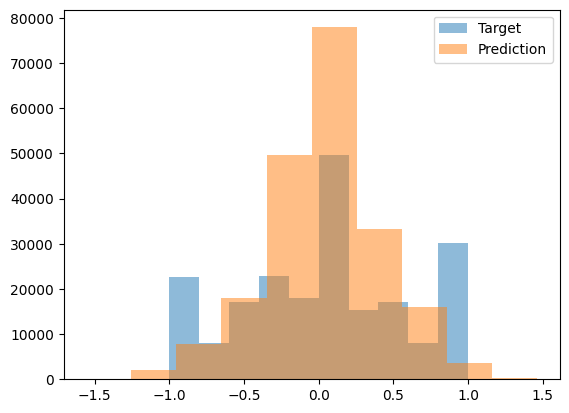

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***